<a href="https://colab.research.google.com/github/afraz-rupak/Superstore-Sales-time-series-forecasting/blob/main/Superstore_Sales_Time_Series_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#https://www.kaggle.com/datasets/rohitsahoo/sales-forecasting

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from lightgbm import LGBMRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import t
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.metrics import mean_absolute_error

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/hiring_COEL-master/superstore sales.csv')

In [ ]:
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,3,CA-2017-138688,12/06/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,4,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,5,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


In [ ]:
type(df['Order Date'])

pandas.core.series.Series

In [ ]:
df['Order Date']= pd.to_datetime(df['Order Date'])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9800 entries, 0 to 9799
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Row ID         9800 non-null   int64         
 1   Order ID       9800 non-null   object        
 2   Order Date     9800 non-null   datetime64[ns]
 3   Ship Date      9800 non-null   object        
 4   Ship Mode      9800 non-null   object        
 5   Customer ID    9800 non-null   object        
 6   Customer Name  9800 non-null   object        
 7   Segment        9800 non-null   object        
 8   Country        9800 non-null   object        
 9   City           9800 non-null   object        
 10  State          9800 non-null   object        
 11  Postal Code    9789 non-null   float64       
 12  Region         9800 non-null   object        
 13  Product ID     9800 non-null   object        
 14  Category       9800 non-null   object        
 15  Sub-Category   9800 n

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Row ID,9800.0,4900.500000,2829.160653,1.000,2450.750,4900.50,7350.250,9800.00
Postal Code,9789.0,55273.322403,32041.223413,1040.000,23223.000,58103.00,90008.000,99301.00
Sales,9800.0,230.769059,626.651875,0.444,17.248,54.49,210.605,22638.48


In [ ]:
#data set making as a new 2 coloumn asa data and price
data = {'Date':df['Order Date'], 
        'Price':df['Sales']} 
newData = pd.DataFrame(data)


In [ ]:
newData = newData.set_index('Date')
newData

,Price
Date,
2017-08-11,261.9600
2017-08-11,731.9400
2017-12-06,14.6200
2016-11-10,957.5775
2016-11-10,22.3680
...,...
2017-05-21,3.7980
2016-12-01,10.3680
2016-12-01,235.1880


In [ ]:
newData=newData.sort_index()

In [ ]:
newData.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9800 entries, 2015-01-02 to 2018-12-30
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   9800 non-null   float64
dtypes: float64(1)
memory usage: 153.1 KB


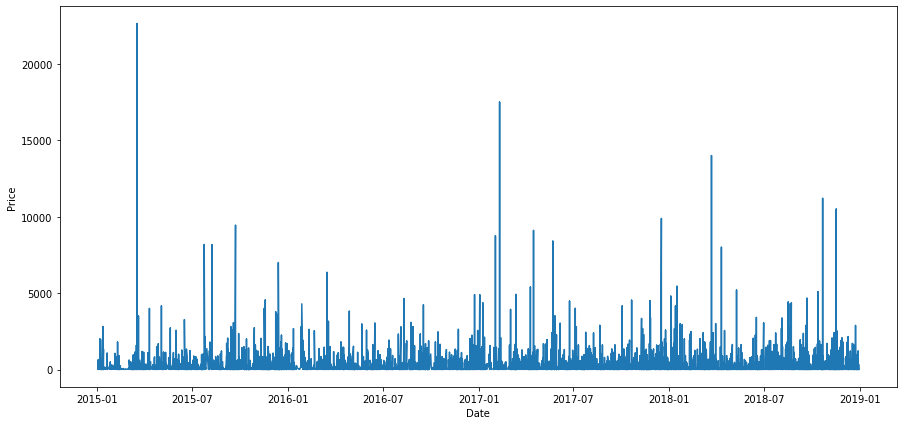

In [ ]:
#plot graph
plt.figure(1 , figsize = (15 , 7))
plt.xlabel("Date")
plt.ylabel("Price")
plt.plot(newData)


In [ ]:
#Determing rolling statistics
rolmean = newData.rolling(window=12).mean()

rolstd = newData.rolling(window=12).std()
print(rolmean, rolstd)

                 Price
Date                  
2015-01-02         NaN
2015-01-03         NaN
2015-01-03         NaN
2015-01-03         NaN
2015-01-03         NaN
...                ...
2018-12-30  221.234833
2018-12-30  232.971500
2018-12-30  215.467333
2018-12-30  209.598000
2018-12-30  186.126667

[9800 rows x 1 columns]                  Price
Date                  
2015-01-02         NaN
2015-01-03         NaN
2015-01-03         NaN
2015-01-03         NaN
2015-01-03         NaN
...                ...
2018-12-30  341.716319
2018-12-30  338.394574
2018-12-30  339.985782
2018-12-30  337.228403
2018-12-30  339.974498

[9800 rows x 1 columns]


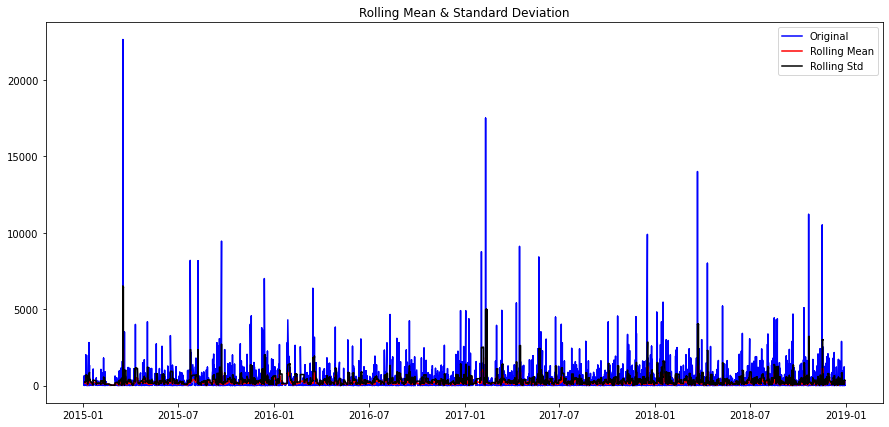

In [ ]:
#plot rolling statistics
plt.figure(1 , figsize = (15 , 7))
orig = plt.plot(newData,color='blue',label='Original')
mean = plt.plot(rolmean,color='red',label='Rolling Mean')
std = plt.plot(rolstd,color='black',label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block= False)

In [ ]:
newData

,Price
Date,
2015-01-02,468.900
2015-01-03,5.940
2015-01-03,457.568
2015-01-03,17.472
2015-01-03,63.552
...,...
2018-12-30,52.776
2018-12-30,209.300
2018-12-30,90.930


In [ ]:
newData = newData.dropna()

In [ ]:
#perform Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(newData['Price'],autolag='AIC')

dfoutput = pd.DataFrame(dftest[0:4], index=['Test Statistics','p-value','#Lags Used','Number of Observations Used'])
for key, value in dftest[4].items():
  dfoutput['Critical value (%s)'%key] = value

print(dfoutput)

Results of Dickey-Fuller Test:
                                       0  Critical value (1%)  \
Test Statistics               -43.574384            -3.431018   
p-value                         0.000000            -3.431018   
#Lags Used                      4.000000            -3.431018   
Number of Observations Used  9795.000000            -3.431018   

                             Critical value (5%)  Critical value (10%)  
Test Statistics                        -2.861835             -2.566927  
p-value                                -2.861835             -2.566927  
#Lags Used                             -2.861835             -2.566927  
Number of Observations Used            -2.861835             -2.566927  


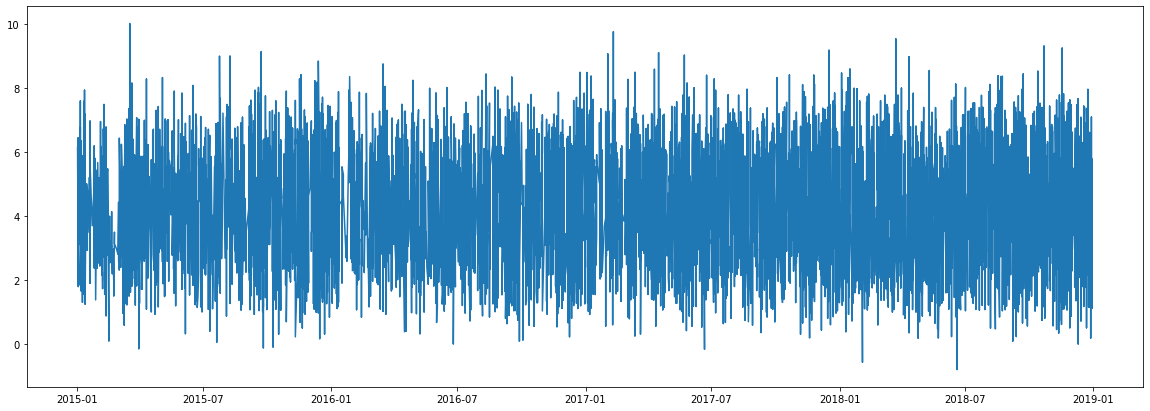

In [ ]:
#Estimating trend
plt.figure(1 , figsize = (20 , 7))
newData_logScale = np.log(newData)
plt.plot(newData_logScale)

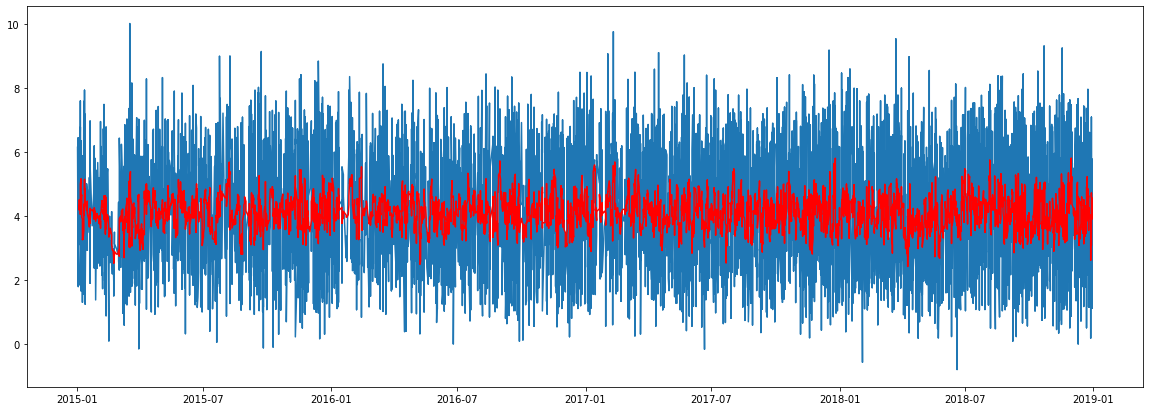

In [ ]:
#Data are in locked form so now make it standard deviation and means
plt.figure(1 , figsize = (20 , 7))
movingAvarage = newData_logScale.rolling(window=12).mean()
movingSTD = newData_logScale.rolling(window=12).std()
plt.plot(newData_logScale)
plt.plot(movingAvarage, color='red')

In [ ]:
datasetLogScaleMinusMovingAverage = newData_logScale - movingAvarage
datasetLogScaleMinusMovingAverage.head(12)

#Removing Nan Values
datasetLogScaleMinusMovingAverage.dropna(inplace= True)
datasetLogScaleMinusMovingAverage.head(10)

,Price
Date,
2015-01-04,-2.660652
2015-01-04,-0.873640
2015-01-04,-1.511093
2015-01-04,0.014778
2015-01-06,2.266003
2015-01-06,0.350240
2015-01-06,-1.333972
2015-01-06,-0.109211
2015-01-06,-0.251015


In [ ]:
#Actual code of dickey-fuller adduller

from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):

  #Determinig rolling statistics
  movingAvarage = timeseries.rolling(window=12).mean()
  movingSTD = timeseries.rolling(window=12).std()

  #Plot rolling statistics
  orig = plt.plot(timeseries, color='blue',label='Orginal')
  mean = plt.plot(movingAvarage, color='red',label='Rolling Mean')
  std = plt.plot(movingSTD, color='black',label='Rolling Std')
  plt.legend(loc='best')
  plt.title('Rolling Mean & Standard Deviation')
  plt.show(block= False) 

  #perform Dickey-Fuller test:
  print ('Results of Dickey-Fuller Test:')
  dftest = adfuller(newData['Price'],autolag='AIC')

  dfoutput = pd.DataFrame(dftest[0:4], index=['Test Statistics','p-value','#Lags Used','Number of Observations Used'])
  for key, value in dftest[4].items():
     dfoutput['Critical value (%s)'%key] = value

  print(dfoutput)


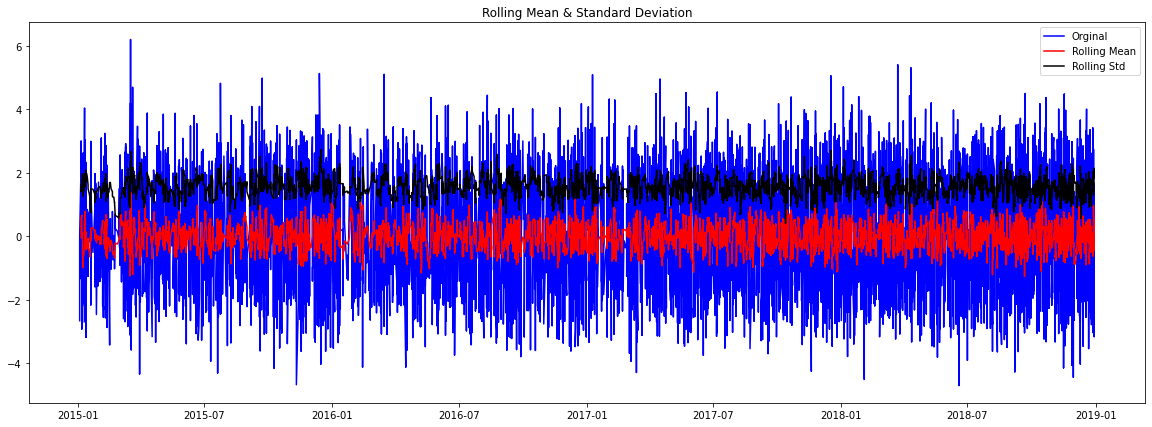

Results of Dickey-Fuller Test:
                                       0  Critical value (1%)  \
Test Statistics               -43.574384            -3.431018   
p-value                         0.000000            -3.431018   
#Lags Used                      4.000000            -3.431018   
Number of Observations Used  9795.000000            -3.431018   

                             Critical value (5%)  Critical value (10%)  
Test Statistics                        -2.861835             -2.566927  
p-value                                -2.861835             -2.566927  
#Lags Used                             -2.861835             -2.566927  
Number of Observations Used            -2.861835             -2.566927  


In [ ]:
plt.figure(1 , figsize = (20 , 7))
test_stationarity(datasetLogScaleMinusMovingAverage)

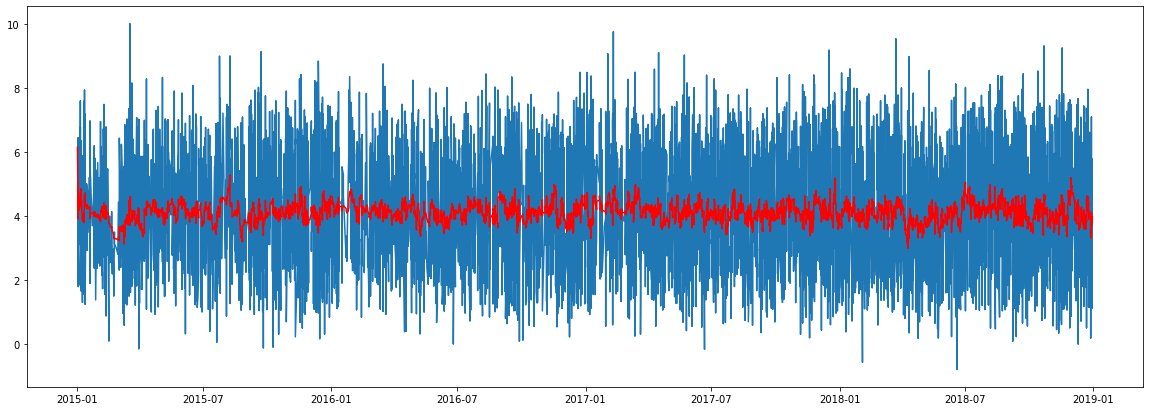

In [ ]:
#calculating timeseries
plt.figure(1 , figsize = (20 , 7))
exponentialDecayWeighteAverage = newData_logScale.ewm(halflife=12, min_periods =0,adjust=True).mean()
plt.plot(newData_logScale)
plt.plot(exponentialDecayWeighteAverage, color='red')

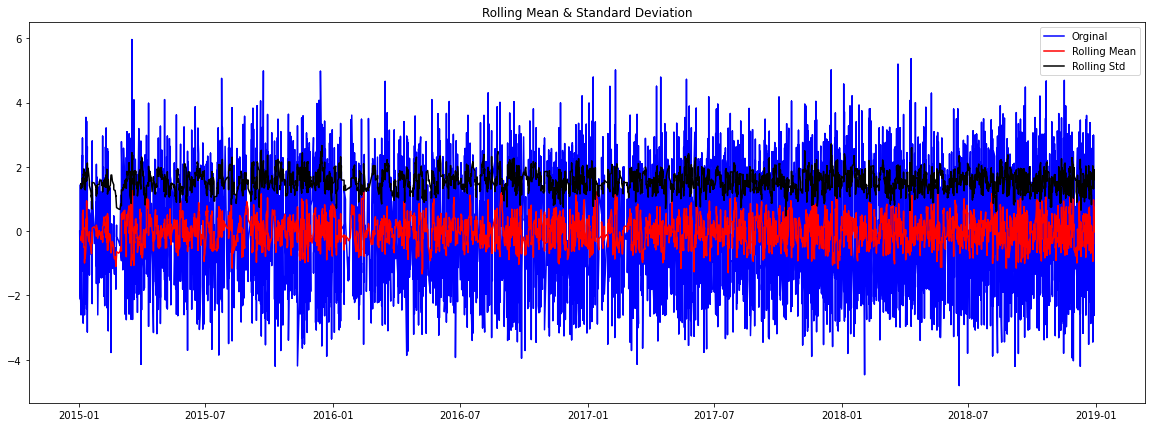

Results of Dickey-Fuller Test:
                                       0  Critical value (1%)  \
Test Statistics               -43.574384            -3.431018   
p-value                         0.000000            -3.431018   
#Lags Used                      4.000000            -3.431018   
Number of Observations Used  9795.000000            -3.431018   

                             Critical value (5%)  Critical value (10%)  
Test Statistics                        -2.861835             -2.566927  
p-value                                -2.861835             -2.566927  
#Lags Used                             -2.861835             -2.566927  
Number of Observations Used            -2.861835             -2.566927  


In [ ]:
plt.figure(1 , figsize = (20 , 7))
datasetLogScaleMinusMovingExponentialDecayAverage = newData_logScale - exponentialDecayWeighteAverage
test_stationarity(datasetLogScaleMinusMovingExponentialDecayAverage)

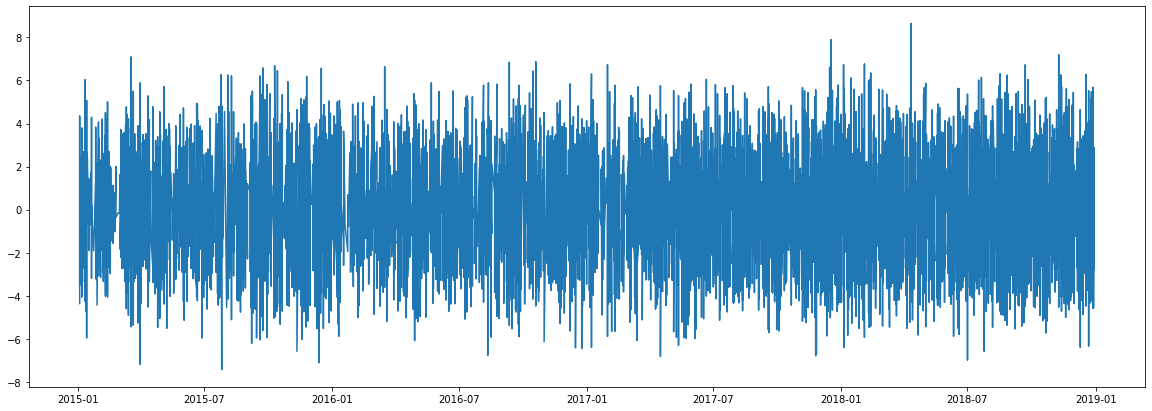

In [ ]:
plt.figure(1 , figsize = (20 , 7))
datasetLogDiffShifting = newData_logScale - newData_logScale.shift()
plt.plot(datasetLogDiffShifting)

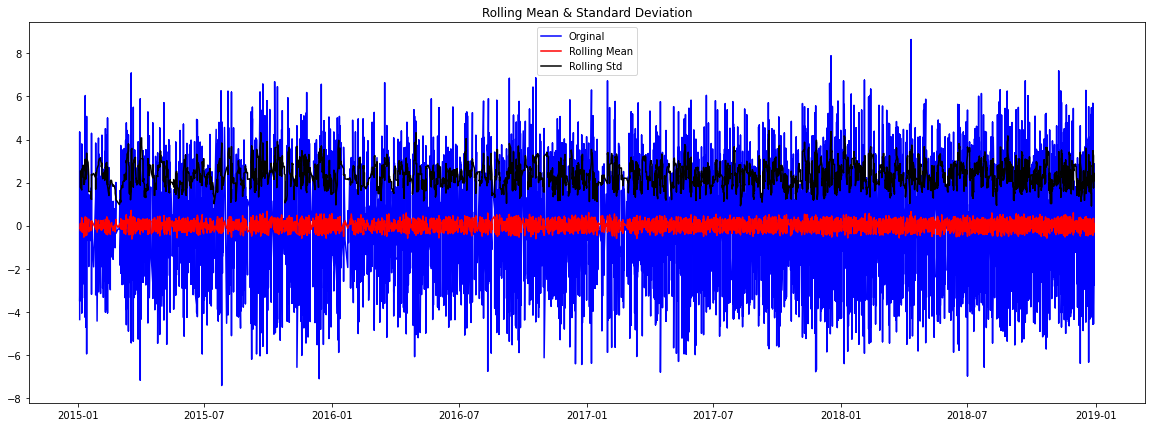

Results of Dickey-Fuller Test:
                                       0  Critical value (1%)  \
Test Statistics               -43.574384            -3.431018   
p-value                         0.000000            -3.431018   
#Lags Used                      4.000000            -3.431018   
Number of Observations Used  9795.000000            -3.431018   

                             Critical value (5%)  Critical value (10%)  
Test Statistics                        -2.861835             -2.566927  
p-value                                -2.861835             -2.566927  
#Lags Used                             -2.861835             -2.566927  
Number of Observations Used            -2.861835             -2.566927  


In [ ]:
plt.figure(1 , figsize = (20 , 7))
datasetLogDiffShifting.dropna(inplace=True)
test_stationarity(datasetLogDiffShifting)

In [ ]:
newData_logScale

,Price
Date,
2015-01-02,6.150390
2015-01-03,1.781709
2015-01-03,6.125926
2015-01-03,2.860600
2015-01-03,4.151858
...,...
2018-12-30,3.966057
2018-12-30,5.343769
2018-12-30,4.510090


In [ ]:
newData_logScale.sort_index(inplace=True)

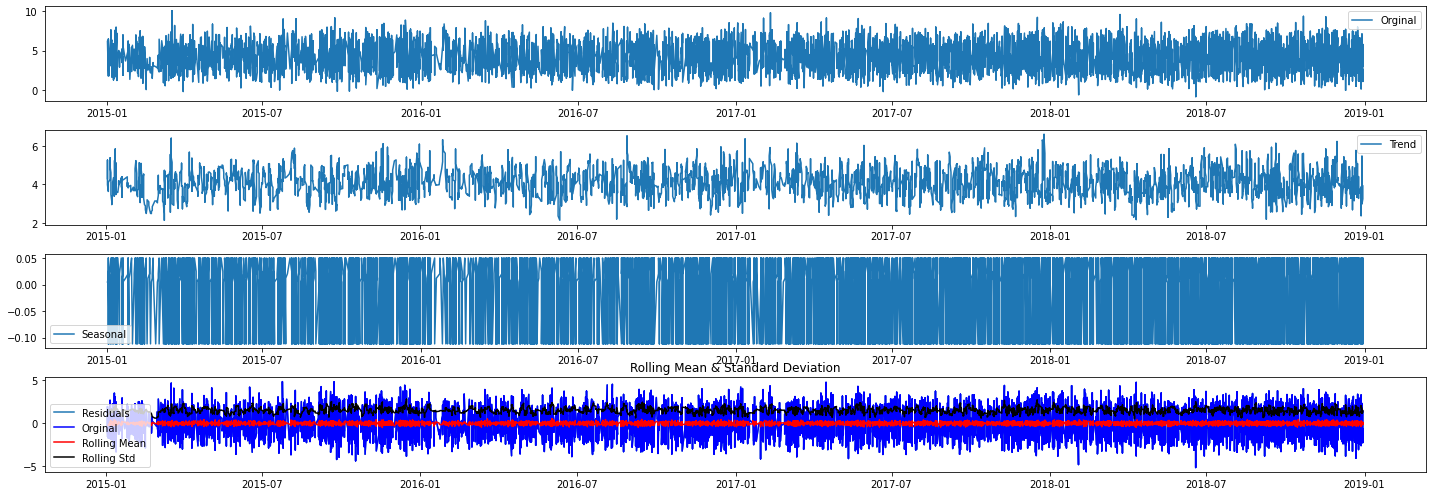

Results of Dickey-Fuller Test:
                                       0  Critical value (1%)  \
Test Statistics               -43.574384            -3.431018   
p-value                         0.000000            -3.431018   
#Lags Used                      4.000000            -3.431018   
Number of Observations Used  9795.000000            -3.431018   

                             Critical value (5%)  Critical value (10%)  
Test Statistics                        -2.861835             -2.566927  
p-value                                -2.861835             -2.566927  
#Lags Used                             -2.861835             -2.566927  
Number of Observations Used            -2.861835             -2.566927  


In [ ]:
from unicodedata import decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(newData_logScale, model='additive', filt=None, period=6, two_sided=True, extrapolate_trend=0)
plt.figure(1 , figsize = (20 , 7))

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(newData_logScale,label='Orginal')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend,label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonal')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual,label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

decomposedLogData = residual
decomposedLogData.dropna(inplace= True)
test_stationarity(decomposedLogData)


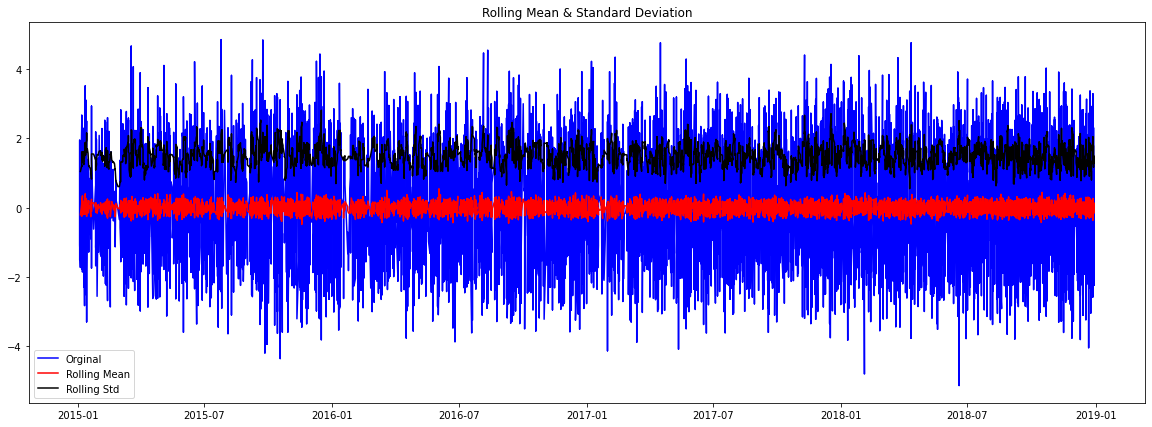

Results of Dickey-Fuller Test:
                                       0  Critical value (1%)  \
Test Statistics               -43.574384            -3.431018   
p-value                         0.000000            -3.431018   
#Lags Used                      4.000000            -3.431018   
Number of Observations Used  9795.000000            -3.431018   

                             Critical value (5%)  Critical value (10%)  
Test Statistics                        -2.861835             -2.566927  
p-value                                -2.861835             -2.566927  
#Lags Used                             -2.861835             -2.566927  
Number of Observations Used            -2.861835             -2.566927  


In [ ]:
plt.figure(1 , figsize = (20 , 7))
decomposedLogData = residual
decomposedLogData.dropna(inplace=True)
test_stationarity(decomposedLogData)

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


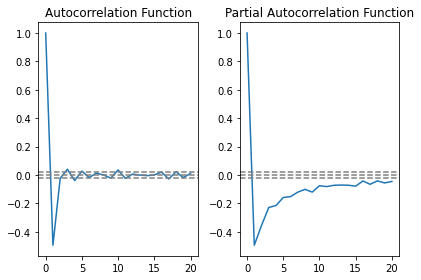

In [ ]:
#ACF AND PACF plots:
from statsmodels.tsa.stattools import acf,pacf

lag_acf = acf(datasetLogDiffShifting, nlags=20)
lag_pacf = pacf(datasetLogDiffShifting, nlags=20,method ='ols')


#plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')


#plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency informa

Plotting AR model


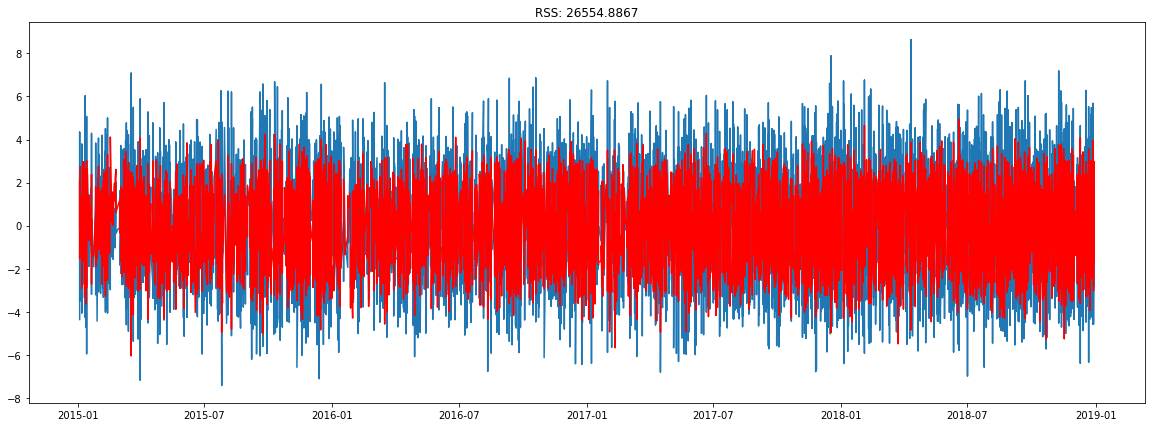

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
plt.figure(1 , figsize = (20 , 7))

#AR MODEL
model = ARIMA(newData_logScale,order=(2 ,1, 2))
results_AR = model.fit(disp = 1)
plt.plot(datasetLogDiffShifting)
plt.plot(results_AR.fittedvalues,color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-datasetLogDiffShifting['Price'])**2))
print('Plotting AR model')

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


Plotting MA model


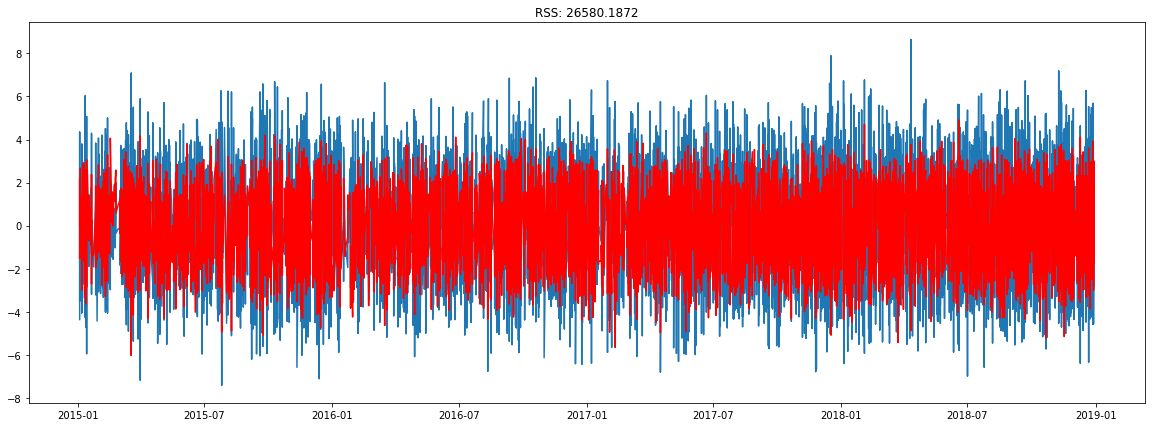

In [ ]:
#MA MODEL
plt.figure(1 , figsize = (20 , 7))
model = ARIMA(newData_logScale,order=(1 ,1, 1))
results_MA = model.fit(disp = 1)
plt.plot(datasetLogDiffShifting)
plt.plot(results_MA.fittedvalues,color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-datasetLogDiffShifting['Price'])**2))
print('Plotting MA model')

/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


Text(0.5, 1.0, 'RSS: 26554.8867')

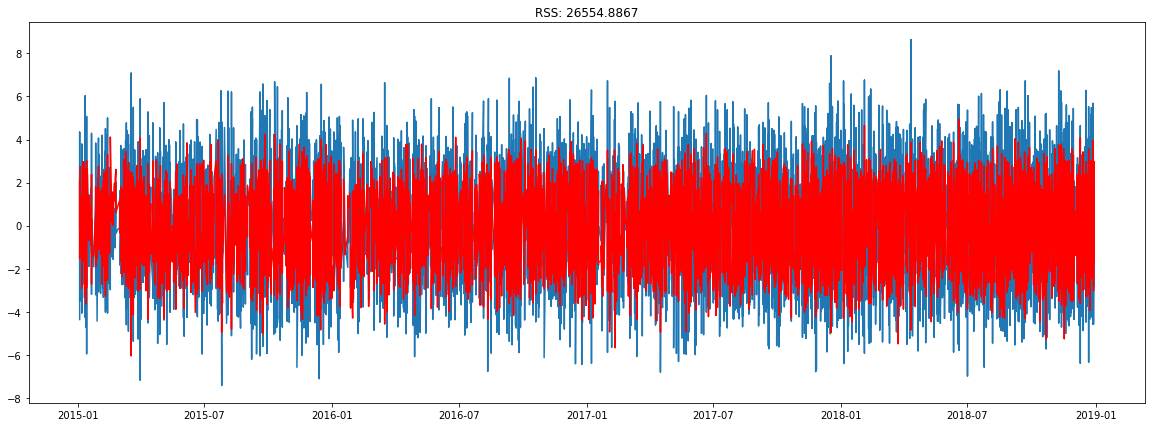

In [ ]:
#ARIMA model combine
plt.figure(1 , figsize = (20 , 7))
model = ARIMA(newData_logScale, order=(2,1,2))
results_ARIMA = model.fit(disp=1)
plt.plot(datasetLogDiffShifting)
plt.plot(results_ARIMA.fittedvalues,color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-datasetLogDiffShifting['Price'])**2))

In [ ]:
predictions_ARIMA_diff = pd.DataFrame(results_ARIMA.fittedvalues, copy= True)
print(predictions_ARIMA_diff.head())

                   0
Date                
2015-01-03 -0.000003
2015-01-03  2.134058
2015-01-03 -1.329035
2015-01-03  1.263766
2015-01-03  0.183431


In [ ]:
#convert to cumulative sum 

predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.head())

                   0
Date                
2015-01-03 -0.000003
2015-01-03  2.134055
2015-01-03  0.805019
2015-01-03  2.068786
2015-01-03  2.252217


In [ ]:
predictions_ARIMA_log = pd.Series(newData_logScale['Price'].iloc[0],index= newData_logScale.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum[0],fill_value=0) 
predictions_ARIMA_log.head()

Date
2015-01-02    6.150390
2015-01-03    6.150386
2015-01-03    8.284444
2015-01-03    6.955409
2015-01-03    8.219175
dtype: float64

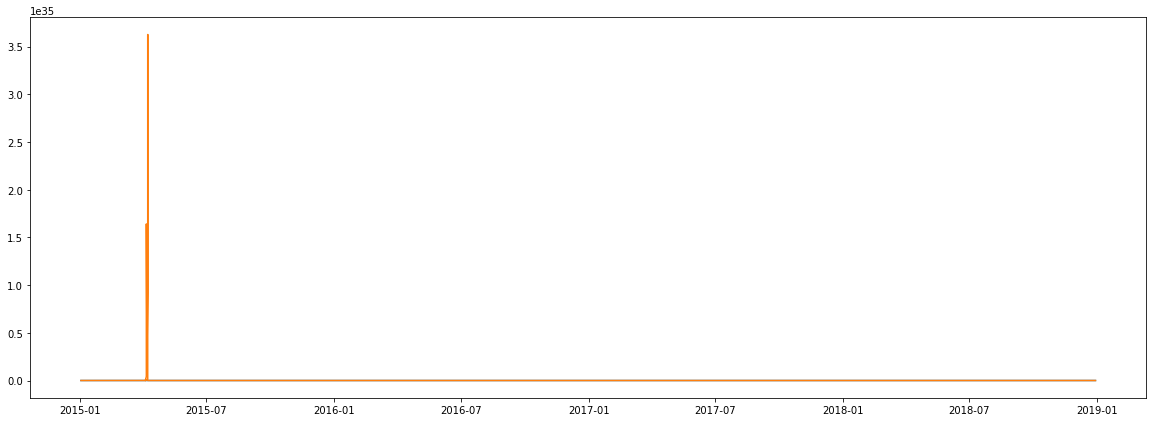

In [ ]:
plt.figure(1 , figsize = (20 , 7))
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(newData)
plt.plot(predictions_ARIMA)

In [ ]:
newData_logScale

,Price
Date,
2015-01-02,6.150390
2015-01-03,1.781709
2015-01-03,6.125926
2015-01-03,2.860600
2015-01-03,4.151858
...,...
2018-12-30,3.966057
2018-12-30,5.343769
2018-12-30,4.510090


/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/usr/local/lib/python3.8/dist-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


<Figure size 1440x504 with 0 Axes>

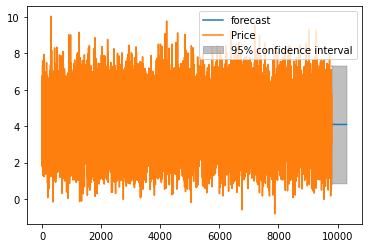

In [ ]:
results_ARIMA.plot_predict(1,10300)
x= results_ARIMA.forecast(steps=120)
#19926

In [ ]:
x

(array([4.06513574, 4.13837715, 4.06475401, 4.11540607, 4.08103568,
        4.10433383, 4.0885322 , 4.0992401 , 4.09197464, 4.09689504,
        4.09355348, 4.09581349, 4.09427566, 4.09531275, 4.09460406,
        4.095079  , 4.09475144, 4.09496798, 4.09481562, 4.09491337,
        4.09484154, 4.09488469, 4.09484989, 4.09486793, 4.09485015,
        4.09485666, 4.09484669, 4.0948479 , 4.09484153, 4.0948403 ,
        4.09483559, 4.09483323, 4.09482928, 4.09482641, 4.0948228 ,
        4.0948197 , 4.09481625, 4.09481304, 4.09480967, 4.0948064 ,
        4.09480307, 4.09479978, 4.09479646, 4.09479316, 4.09478985,
        4.09478654, 4.09478323, 4.09477993, 4.09477662, 4.09477331,
        4.09477   , 4.0947667 , 4.09476339, 4.09476008, 4.09475678,
        4.09475347, 4.09475016, 4.09474685, 4.09474355, 4.09474024,
        4.09473693, 4.09473362, 4.09473032, 4.09472701, 4.0947237 ,
        4.09472039, 4.09471709, 4.09471378, 4.09471047, 4.09470716,
        4.09470386, 4.09470055, 4.09469724, 4.09